# Imports

In [1]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import ConstantPopulationSize, AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [2]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           plot_parameter_sensitivity,
                           plot_parameters_kde)

INFO:myokit:Loading Myokit version 1.27.4


In [3]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [4]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Create ion channel model

In [5]:
from channels.ito import ito as model
#model.sample({})

# Get experimental measurements

In [6]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [7]:
limits = dict(g_to=(0, 1),
              k_xss1=(0, 10),
              k_xss2=(0, 100),
              k_xtau1=(0, 10),
              k_xtau2=(0, 100),
              k_xtau3=(0, 100),
              k_yss1=(0, 100),
              k_yss2=(0, 100),
              k_ytau1=(0, 100),
              k_ytau2=(0, 100),
              k_ytau3=(0, 100),
              k_ytau4=(0, 100))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Test parameter sensitivity

In [9]:
parameters = ['ito.'+k for k in limits.keys()]

In [11]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

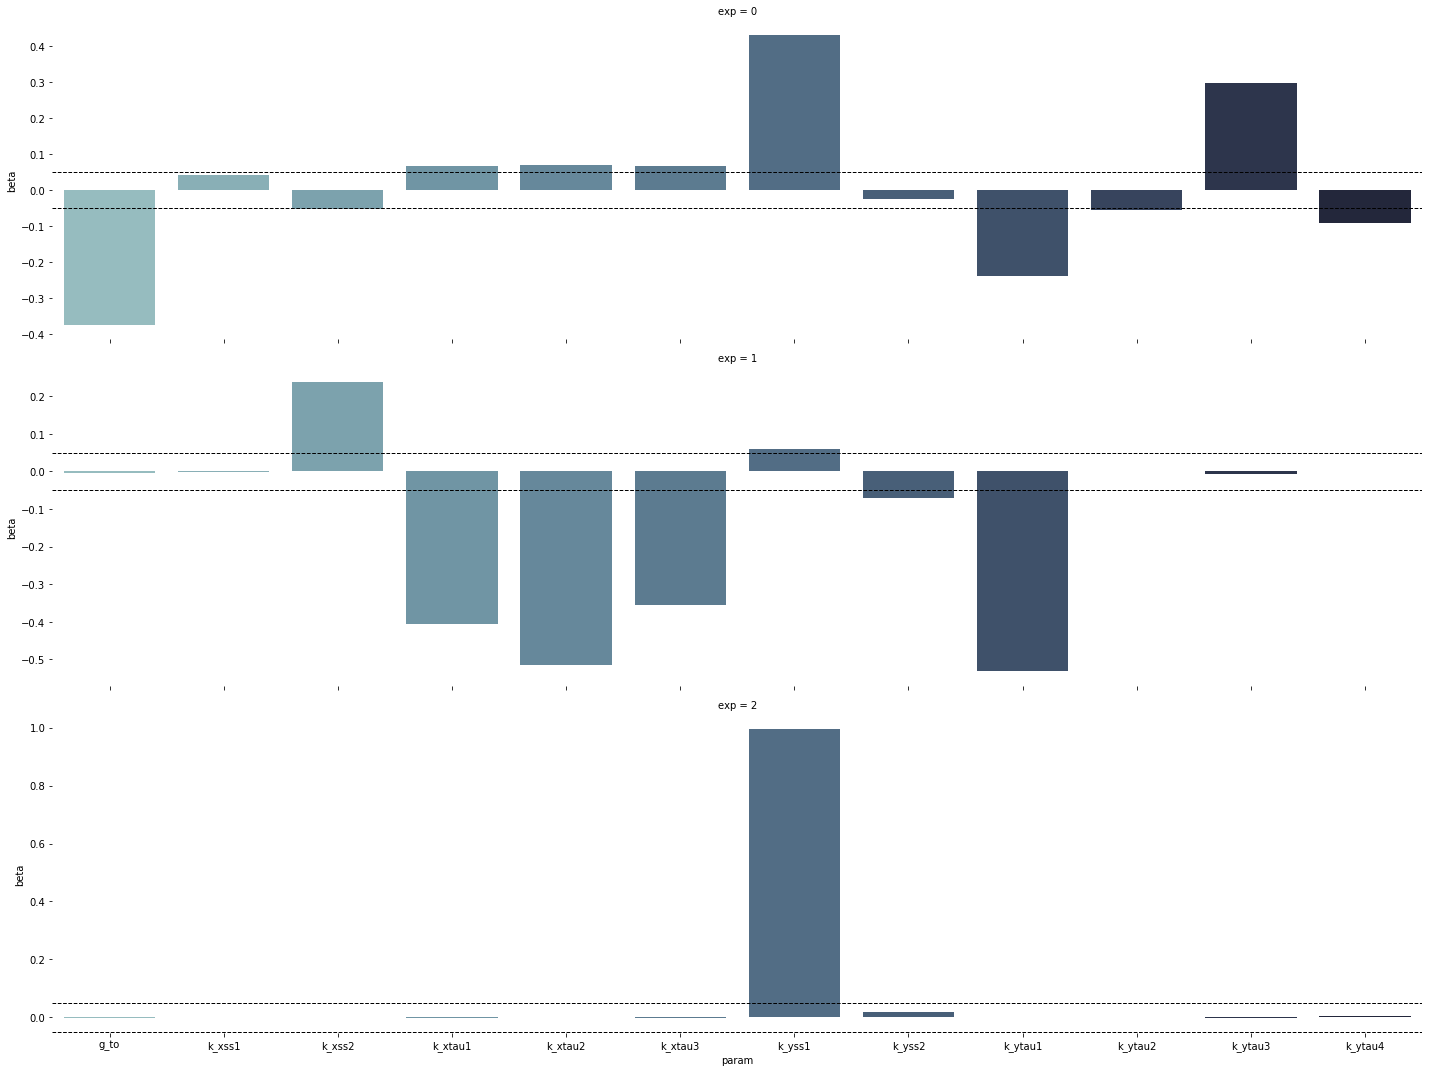

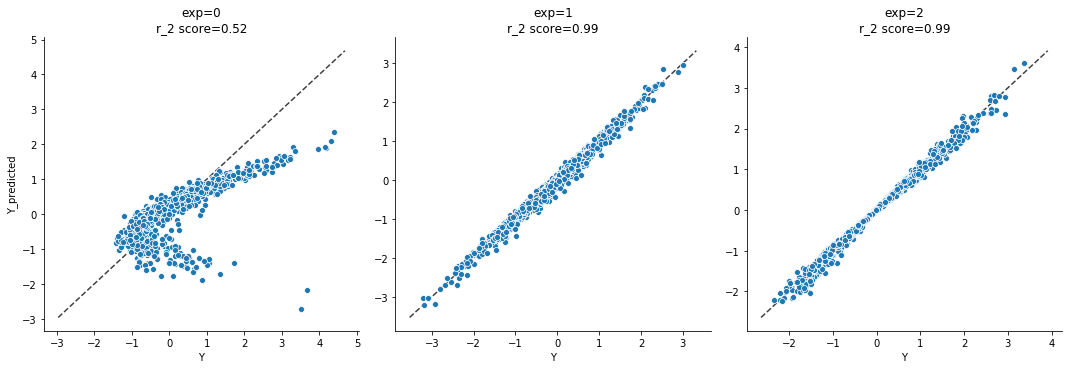

In [15]:
grid1, grid2 = plot_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.1,
    n_samples=1000,
    plot_cutoff=0.05)

In [16]:
grid1.savefig('results/ito/sensitivity.pdf')
grid2.savefig('results/ito/sensitivity_fit.pdf')

# Initialise pyabc database

In [11]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_ito.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_ito.db


In [19]:
abc = ABCSMC(models=myokit_model,
             parameter_priors=prior,
             distance_function=PrangleDistance(
                 exp_map=exp,
                 alpha=0.5,
                 delta=0.5,
                 adapt=False),
             population_size=PranglePopulationSize(
                 500, alpha=0.5,
                 adapt=True,
                 mean_cv=0.5,
                 min_population_size=200,
                 max_population_size=5000),
             eps=PrangleEpsilon(100, alpha=0.5))

In [12]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [13]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             #population_size=ConstantPopulationSize(
             #    nr_particles=5000),
             population_size=AdaptivePopulationSize(
                 start_nr_particles=2500,
                 mean_cv=0.5,
                 max_population_size=5000,
                 min_population_size=500),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=24),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.28000483001869525, 1: 0.28000483001869525, 2: 0.28000483001869525, 3: 0.28000483001869525, 4: 0.28000483001869525, 5: 0.28000483001869525, 6: 0.28000483001869525, 7: 0.25303936896267654, 8: 0.22088811308980946, 9: 0.17954942768846782, 10: 0.15514335966426648, 11: 0.24096649623380578, 12: 0.34990528496385936, 13: 0.32069909158384313, 14: 0.38470941572561096, 15: 0.4046907051929525, 16: 0.42717066503692636, 17: 0.38491728580794116, 18: 3.710177692724231, 19: 0.6379695788708737, 20: 0.8437662172163188, 21: 2.906305859300656, 22: 2.377886612155085, 23: 2.1797293944754856, 24: 3.710177692724231, 25: 1.4531529296503196, 26: 1.188943306077537, 27: 3.710177692724231}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1


In [14]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2018-08-30 11:33:57.495767, end_time=None)>
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc/epsilon.py:321: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = weighted_distances.distance.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc/epsilon.py:325: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  weights = weighted_distances.w.as_matrix()
INFO:Epsilon:initial epsilon is 14.072438477405823


In [18]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=20, min_acceptance_rate=0.001)

INFO:ABC:t:60 eps:0.23535602216257773
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc/smc.py:729: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.history.max_t)["p"].as_matrix()
INFO:Adaptation:Change nr particles 5000 -> 5000
DEBUG:ABC:now submitting population 60
DEBUG:ABC:population 60 done
DEBUG:ABC:
total nr simulations up to t =60 is 7995821
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc/epsilon.py:321: FutureWarning

# Results analysis

In [8]:
db_path = 'sqlite:///results/ito/hl-1_ito.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-08-30 11:33:57.495767, end_time=2018-09-03 15:23:15.848987)>]

In [9]:
history.id = 1

In [10]:
sns.set_context('talk')

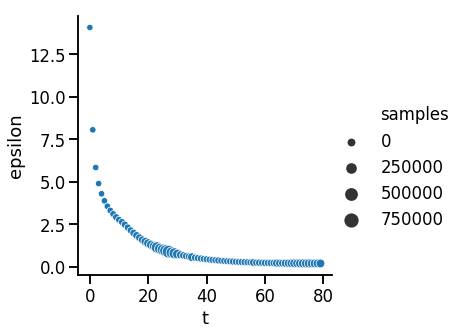

In [11]:
evolution = history.get_all_populations()
grid = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])
grid.savefig('results/ito/eps_evolution.pdf')

In [12]:
df, w = history.get_distribution(m=0)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()


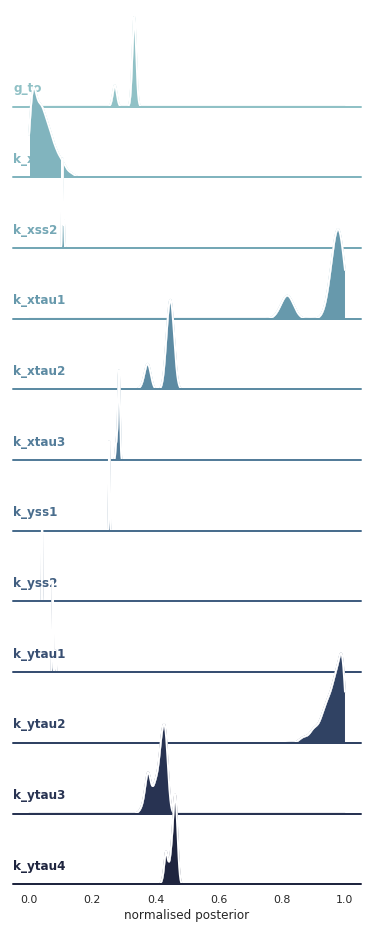

In [13]:
g = plot_parameters_kde(df, w, limits, aspect=5, height=1.1)

In [14]:
g.savefig('results/ito/parameters_kde.pdf')

# Samples for quantitative analysis

In [15]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


In [16]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


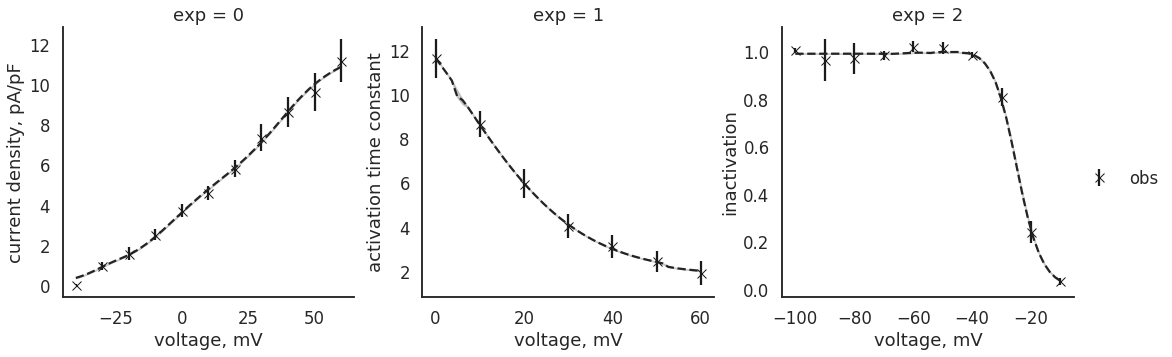

In [17]:
from ionchannelABC import plot_sim_results
sns.set_context('talk')
g = plot_sim_results(samples, obs=measurements)

# Set axis labels
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV"]
ylabels = ["current density, pA/pF", "activation time constant", "inactivation"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)

In [18]:
g.savefig('results/ito/ito_sim_results.pdf')

In [19]:
# Fit activation time constants
grouped = samples[samples['exp']==1].groupby('sample')

In [20]:
from scipy.optimize import curve_fit
def fit_single_exp(group):
    def single_exp(V, a, b, c):
        return a + b*(np.exp(-V/c))
    guess = (1, 10, 30)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_single_exp).apply(pd.Series)

In [21]:
print(output.mean())
print(output.std())

0     0.693516
1    11.346714
2    26.009547
dtype: float64
0    0.067142
1    0.064778
2    0.400484
dtype: float64


In [22]:
import scipy.stats as st
a = output[0].tolist()
rv = st.rv_discrete(values=(a, [1/len(a),]*len(a)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 0.698940394909814
95% CI: (0.5624895996636707, 0.7990268921811594)


In [23]:
b = output[1].tolist()
rv = st.rv_discrete(values=(b, [1/len(b),]*len(b)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 11.346714970616826
95% CI: (11.218115990734853, 11.479266371921778)


In [25]:
c = output[2].tolist()
rv = st.rv_discrete(values=(c, [1/len(c),]*len(c)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 26.00068489921095
95% CI: (25.23582943151088, 26.870679423724155)


In [26]:
# Steady-state inactivation fit to Boltzmann
grouped = samples[samples['exp']==2].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((V-Vhalf)/Shalf))
    guess = (50, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [27]:
print(output.mean())
print(output.std())

0   -24.478147
1     4.032313
dtype: float64
0    0.136882
1    0.079504
dtype: float64


In [28]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -24.48606536212124
95% CI: (-24.767748128562673, -24.23665583915842)


In [30]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 4.041529219873673
95% CI: (3.869016395723247, 4.170651871570859)


# Weights of distance function

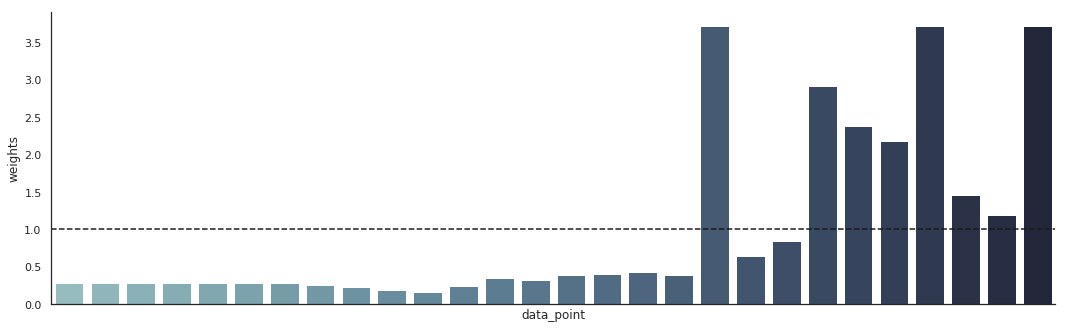

In [34]:
from ionchannelABC import plot_distance_weights
grid = plot_distance_weights(model, distance_fn)

In [35]:
grid.savefig('results/ito/dist_weights.pdf')